- Ctrl+Enter to run a cell
- Shift+Enter to run a cell and go to the next cell
- **Download this Notebook file [here](http://pmx.mpibpc.mpg.de/Tutorial2024/Solvation_FE/Solvation_Free_Energy.ipynb)**

## Basic Background

Solvation free energy (or free energy of solvation) is generally defined as the energy required to dissolve a solute in a solvent. In other words, it is the difference in the free energy of the solute in vacuum and in the solvent phase. Solvation free energy is a fundamental thermodynamic quantity that helps to estimate various physicochemical properties of a solute. Accurately predicting solvation free energy is thus important to several research fields, including drug design, materials science, and environmental chemistry. There are many approaches for calculating solvation free energy, such as implicit and explicit solvent models, alchemical methods, and machine learning algorithms.


Inhere, we will estimate the solvation free energy of **aniline** molecule using (non-equillibrium) alchemical free energy method (the figure below). GROMACS-2021.7 (any other version should be fine) will be employed for the system set up and molecular dynamics simulations, whereas the analyses will be done with PMX. PMX also helps in hybrid structure and topology preparation as well as in the generation of efficient workflow while dealing with more complex problems, such as estimation of free energy change due to protein mutation, protein-ligand absolute/relative binding free energy, whose [tutorials are covered here](http://pmx.mpibpc.mpg.de/).

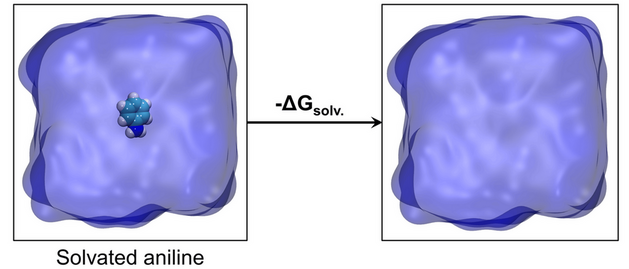

## Prerequisite

- Knowledge of basic linux commands and python.
- An already installed GROMACS and a basic understanding of GROMACS simulation set up is required. You can follow [this tutorial](https://tutorials.gromacs.org/docs/md-intro-tutorial.html) for the same.
- PMX installation. Follow the [instruction here](https://github.com/deGrootLab/pmx/blob/develop/tutorials/INSTALL).
- **Input Files:** The [input_file.zip](http://pmx.mpibpc.mpg.de/Tutorial2024/Solvation_FE/input_files.zip) contains all the files required to run this tutorial. **mdp**: required mdp files; **topol**: required topology files; **MOL.gro**: the structure file of aniline; **pre-simulated-files**: some pre-simulated files required for this tutorial.

## Workflow

The workflow of the solvation free energy estimation is sketched in the following figure and explained below in detail.

If you are not interested in the details of various parameters, you can directly skip to the **Simulations** section.

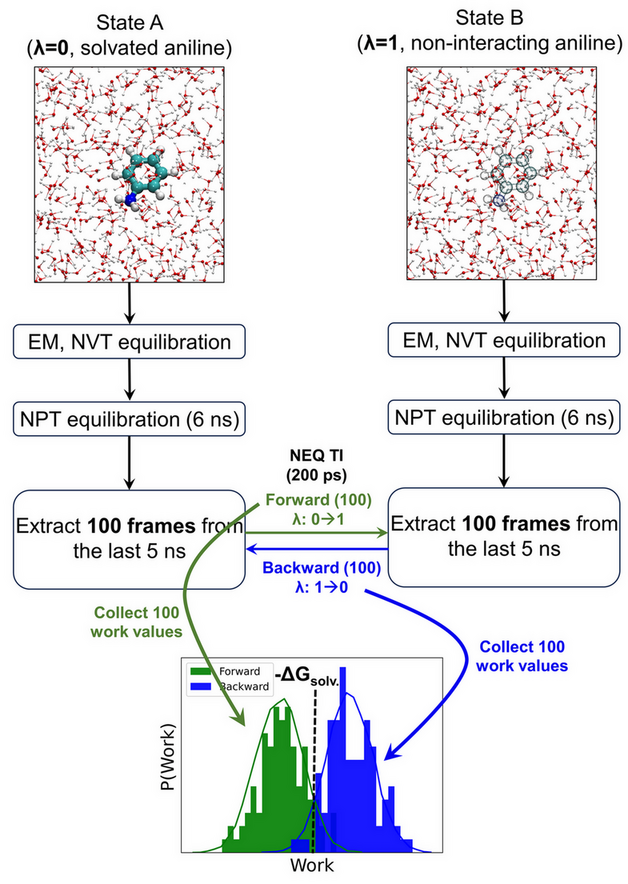

- Firstly, we need to **generate the force field parameters for aniline**, which is not covered in this tutorial. The GAFF2 parameters for aniline is already generated and provided (as a part of the input_file.zip). One can get the GAFF2 parameters of aniline using [AmberTools](https://ambermd.org/AmberTools.php).


The estimation of free energy difference using non-equilibrium alchemy requires an extensive (and only) sampling of the end states (λ = 0 and λ = 1). For this tutorial, these two end states the fully solvated aniline (λ = 0) and non-interacting aniline (λ = 1).


Both the end states use the same topology files; they are defined as λ=0/1 in "Free Energy" section of the MDP files. Note that mdp files for each step (em, eq_nvt, eq) are provided twice with suffix "_l0" and "_l1" for λ=0 and λ=1, respectively. Let's have a look into the "Free Energy" section of the em_l0.mdp file (input_file.zip).

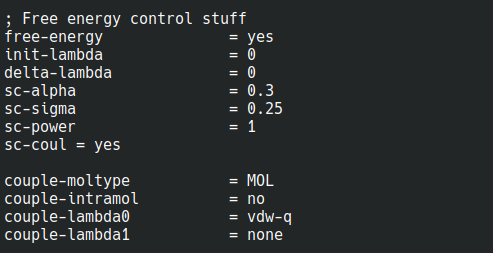

-- **free-energy:** The control for free energy calculation. yes/no : on/off.


-- **init-lambda:** The lambda value (0 or 1) to define the states. This keywork differentiate the two end states (solvated aniline: 0; non-interacting aniline: 1).


-- **delta-lambda, sc-alpha, sc-sigma, sc-power, sc-couple:** Not important here. These are explained later.


-- **couple-moltype:** The molecule type of aniline in the topology file. It is defined as "MOL".


-- **couple-intramol:** The way of treating intramolecular non-bonded interactions of the molecule defined in 'couple-moltype'. *no*: All intra-molecular non-bonded interactions are replaced by exclusions and explicit pair interactions. **In this manner the decoupled state of the molecule corresponds to the proper vacuum state without periodicity effects**. *yes*: The intra-molecular Van der Waals and Coulomb interactions are also turned on/off.


-- **couple-lambda0:** vdw-q: All interactions (van der Waals and electrostatic) are on at λ=0.


-- **couple-lambda1:** none: All interactions (van der Waals and electrostatic) are off at λ=1.


As you might have noticed, the only difference between em_l0.mdp and em_l1.mdp files is the value for the init-lambda keyword.

Next, both the end states are subjected to the following steps.

- The standard GROMACS protocol of **system preparation/equilibration**, i.e, simulation box generation, solvation, energy minimization, and nvt equilibration.
- The system was then simluated in the **NPT ensemble for 6 ns**, out of which the first 1 ns will be discarded as further equilibration phase.
- 100 frames are extracted from the 5 ns trajectory, dumped every 50 ps. These frames are used for 100 short non-equilibrium transitions (200 ps each), and the transition is controlled by parameters defined in the mdp files (ti_l0.mdp, ti_l1.mdp).

Let's have a look into the remaining free energy controlling parameters in ti_l0.mdp

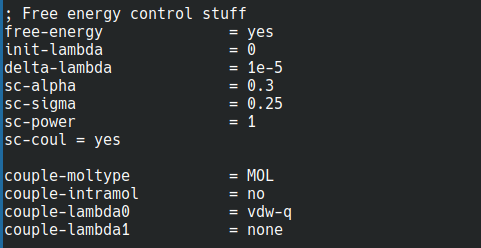

-- **delta-lambda:** The rate at which the transition is carried out from one state to the other (0 to 1). It's just the inverse of number of md steps. In our case, it's 1/100000 = 1e-5 (for 200 ps transition time and 2 fs time step).

-- **sc-couple:** Whether to apply the soft-core free energy interaction transformation to the Columbic interaction of a molecule.

-- **sc-alpha, sc-sigma, sc-power:** Various parameters for the soft-core transformation. As you might have noticed, these parameters are irrelevant with delta-lambda=0.

**Great!! Now that we have an understanding of the workflow, let's jump into the water and get solvated :).**

## Simulations

### Import essential modules

In [ ]:
import pmx
from pmx import gmx
import sys, os
import numpy as np
import glob, subprocess

gmx.set_gmxlib()

Some useful functions are defined.

In [ ]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
def clean_backup_files(path):
    toclean = glob.glob('{0}/*#'.format(path)) 
    for clean in toclean:
        os.remove(clean)

### Download the input files and create directory structure

In [ ]:
cwd = os.getcwd()
sim_dir = '{0}/Simulations'.format(cwd)
create_folder(sim_dir)
subprocess.call('wget http://pmx.mpibpc.mpg.de/Tutorial2024/Solvation_FE/input_files.zip {0}'.format(cwd), shell=True) #Download input_files.zip
subprocess.call('unzip {0}/input_files.zip -d {1}/'.format(cwd, sim_dir), shell=True)

simtypes = ['em', 'eq_nvt', 'eq', 'transitions']

for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)
    create_folder(state_dir)
    subprocess.call("cp -r {0}/topol {1}".format(sim_dir, state_dir), shell=True)
    for simtype in simtypes:
        create_folder('{0}/{1}'.format(state_dir, simtype))
        
print('Directory structure created as:')
print('|--- Simulations')
print('|---|--- state0;state1')
print('|---|---|--- em;eq_nvt;eq;transitions')

### System preparation, Energy minimization, Equilibrations

**System Preparation:** GROMACS *editconf* and *solvate* modules are used.

In [ ]:
# System Preparation
ff = 'amber99sb-star-ildn-mut.ff'
boxshape = 'dodecahedron'
boxd = 1.5
water = 'tip3p'


## Create simulation box
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)    
    inStr = '{0}/MOL.gro'.format(sim_dir)
    outStr = '{0}/box.pdb'.format(state_dir)
    gmx.editconf(inStr, o=outStr, bt=boxshape, d=boxd, other_flags='')      

    
## Solvate the simulation box
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)  
    top_dir = '{0}/topol/'.format(state_dir)
    inStr = '{0}/box.pdb'.format(state_dir)
    outStr = '{0}/water.pdb'.format(state_dir)
    top = '{0}/topol.top'.format(top_dir)
    gmx.solvate(inStr, cs='spc216.gro', p=top, o=outStr)
    clean_backup_files(state_dir)    

**Energy Minimization:** Again, standard *grompp* and *mdrun* modules are employed for tpr file generation and simulation run.

In [ ]:
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)  
    top_dir = '{0}/topol/'.format(state_dir)
    mdp = '{0}/mdp/em_l{1}.mdp'.format(sim_dir, state)
    inStr = '{0}/water.pdb'.format(state_dir)
    top = '{0}/topol.top'.format(top_dir)
    mdrun_dir = '{0}/em'.format(state_dir)
    tpr = '{0}/tpr.tpr'.format(mdrun_dir)
    gmx.grompp(f=mdp, c=inStr, p=top, o=tpr, maxwarn=1, other_flags=' -po {0}/mdout.mdp'.format(mdrun_dir))

    os.chdir(mdrun_dir)
    process = subprocess.Popen(['gmx','mdrun',
                        '-s',tpr],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)                   
    process.wait() 
    
    clean_backup_files(mdrun_dir)
    os.chdir(sim_dir)
                                

**NVT Equilibration:** 10 ps of nvt equilibration both the states might take 2-5 minutes in total. I guess we can easily afford waiting for 2-5 minutes.

In [ ]:
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)  
    top_dir = '{0}/topol/'.format(state_dir)
    mdp = '{0}/mdp/eq_nvt_l{1}.mdp'.format(sim_dir, state)
    inStr = '{0}/em/confout.gro'.format(state_dir)
    top = '{0}/topol.top'.format(top_dir)
    mdrun_dir = '{0}/eq_nvt'.format(state_dir)
    tpr = '{0}/tpr.tpr'.format(mdrun_dir)
    
    gmx.grompp(f=mdp, c=inStr, p=top, o=tpr, maxwarn=1, other_flags=' -po {0}/mdout.mdp'.format(mdrun_dir))

    os.chdir(mdrun_dir)
    process = subprocess.Popen(['gmx','mdrun',
                        '-s',tpr],
                        stdout=subprocess.PIPE, 
                        stderr=subprocess.PIPE)                   
    process.wait() 
    
    clean_backup_files(mdrun_dir)
    os.chdir(sim_dir)  

**NPT Equilibration:** 6 ns of npt equilibration both the states might take a few hours in total. Hence, we will skip running the simulations here and use pre-simulated-files provided as a part of input files. (However, it is recommended to run the simulations by yourself.)

In [ ]:
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)  
    top_dir = '{0}/topol/'.format(state_dir)
    mdp = '{0}/mdp/eq_l{1}.mdp'.format(sim_dir, state)
    inStr = '{0}/eq_nvt/confout.gro'.format(state_dir)
    top = '{0}/topol.top'.format(top_dir)
    mdrun_dir = '{0}/eq'.format(state_dir)
    tpr = '{0}/tpr.tpr'.format(mdrun_dir)
    
    gmx.grompp(f=mdp, c=inStr, p=top, o=tpr, maxwarn=1, other_flags=' -po {0}/mdout.mdp'.format(mdrun_dir))    
    clean_backup_files(mdrun_dir)
    
    ## Run the simulations separately in local PC/cluster and wait until it's over.
#     os.chdir(mdrun_dir)
#     process = subprocess.Popen(['gmx','mdrun',
#                         '-s',tpr],
#                         stdout=subprocess.PIPE, 
#                         stderr=subprocess.PIPE)                   
#     process.wait() 
    
#     clean_backup_files(mdrun_dir)
#     os.chdir(sim_dir) 

### Non-equilibrium TI (transitions)

Copy traj.trr and tpr.tpr files from pre-simulated-files ("eq" directories) to your simulation directory.

In [ ]:
for state in [0, 1]:
    source_dir = '{0}/pre-simulated-files/state{1}/eq'.format(sim_dir, state)
    target_dir = '{0}/state{1}/eq'.format(sim_dir, state)
    
    subprocess.call('cp {0}/traj.trr {1}'.format(source_dir, target_dir), shell=True)
    subprocess.call('cp {0}/tpr.tpr {1}'.format(source_dir, target_dir), shell=True)    

Extract 100 frames from the last 5 ns of equilibration trajectory into 'transitions' directory. The files will be named as frame{1..100}.gro.

In [ ]:
for state in [0, 1]:
    trr='{0}/state{1}/eq/traj.trr'.format(sim_dir, state)
    tpr='{0}/state{1}/eq/tpr.tpr'.format(sim_dir, state)    
    outfile='{0}/state{1}/transitions/frame.gro'.format(sim_dir, state)
    
    gmx.trjconv(s=tpr,f=trr,o=outfile, sep=True, ur='compact', pbc='mol', other_flags=' -b 1000') 

Create 100 tpr files using the frame{1..100}.gro files.

In [ ]:
for state in [0, 1]:
    state_dir = '{0}/state{1}'.format(sim_dir, state)  
    top_dir = '{0}/topol/'.format(state_dir)
    mdp = '{0}/mdp/ti_l{1}.mdp'.format(sim_dir, state)
    top = '{0}/topol.top'.format(top_dir)
    mdrun_dir='{0}/transitions'.format(state_dir)
    
    for i in range(1, 101):
        inStr = '{0}/frame{1}.gro'.format(mdrun_dir, i)
        tpr = '{0}/ti{1}.tpr'.format(mdrun_dir, i)

        gmx.grompp(f=mdp, c=inStr, p=top, o=tpr, maxwarn=1, other_flags=' -po {0}/mdout.mdp'.format(mdrun_dir))
        clean_backup_files(mdrun_dir)

Now, we will run 200 short simulations (100 for each state), each of 200 ps length (non-equilibrium). Since this would again take quite a while, we'll skip this step (the next cell) and use the pre-simulated-files. 


Gromacs writes dhdl.xvg files for free energy calculations, which are provided in pre-simulated-files and can be used by PMX for analyses.

In [ ]:
### Run the short transitions here. Wait until they're over.
# for state in [0, 1]:
#     state_dir = '{0}/state{1}'.format(sim_dir, state)  
#     mdrun_dir='{0}/transitions'.format(state_dir)

#     os.chdir(mdrun_dir)
#     for i in range(1, 101):
#         tpr = '{0}/ti{1}.tpr'.format(mdrun_dir, i)
#         dhdl = '{0}/dhdl{1}.xvg'.format(mdrun_dir, i)


#         process = subprocess.Popen(['gmx','mdrun',
#                             '-s',tpr, '-dhdl', dhdl],
#                             stdout=subprocess.PIPE, 
#                             stderr=subprocess.PIPE) # We write only dhdl with indices as {1..100}. We are not interested in other files and hence gromacs is allowed to back them up, 
                                                      # which we then remove with clean_backup_files() function.                   
#         process.wait() 

#         clean_backup_files(mdrun_dir)
#         os.chdir(sim_dir)  

In the above cell, the 200 short simulations are run serially, you can run them in parallel as well in a local cluster

Copy dhdl files from the pre-simulated-files to your simulation directory.

In [ ]:
for state in [0, 1]: 
    source_dir = '{0}/pre-simulated-files/state{1}/transitions'.format(sim_dir, state)
    target_dir = '{0}/state{1}/transitions'.format(sim_dir, state)
    
    subprocess.call('cp {0}/dhdl*.xvg {1}'.format(source_dir, target_dir), shell=True)

### Analysis

The work value can be computed by integrating the dH/d$\lambda$ values from a dhdl.xvg file. We collect all the work values (100 from each forward and backward transitions) calculated from the dH/d$\lambda$ and estimate $\Delta G_{solv}$ from their distributions employing various estimators. The PMX tool is used here for the analyses. The next cell takes ~1 minute to complete.

In [ ]:
# Analysis using PMX
ana_dir = '{0}/Analysis'.format(sim_dir)
create_folder(ana_dir)

fA = ' '.join( glob.glob('{0}/state0/transitions/dhdl*.xvg'.format(sim_dir)) )
fB = ' '.join( glob.glob('{0}/state1/transitions/dhdl*.xvg'.format(sim_dir)) )
oA = '{0}/integ0.dat'.format(ana_dir)
oB = '{0}/integ1.dat'.format(ana_dir)
wplot = '{0}/wplot.png'.format(ana_dir)
o = '{0}/results.txt'.format(ana_dir)

subprocess.call('pmx analyse -fA {0} -fB {1} -o {2} -oA {3} -oB {4} -w {5} -t {6} -b {7}'.format(fA, fB,o,oA,oB,wplot,298,100), shell=True)

Keywords arguments:- **-fA & -fB:** input: dhdl files from the Forward transitions (0-->1) and Backward transitions (1-->0), respectively; 

**-o:** output: file containing results from various estimators such as Bennett Acceptance Ration (BAR), Crooks Gaussian Intersection (CGI) and Jarzynski equality;

**-oA & -oB:** output: files containing work values from forward and backward transitions;

**-w:** output: plot of Forward and Backward work distributions;

**-t:** input: temperature (K); **-b:** input: number of bootstrap samples

Let's have look into the work distribution generated in the previous step (Analysis/wplot.png). You're encouraged to check all the outputs in the "Analysis" folder.

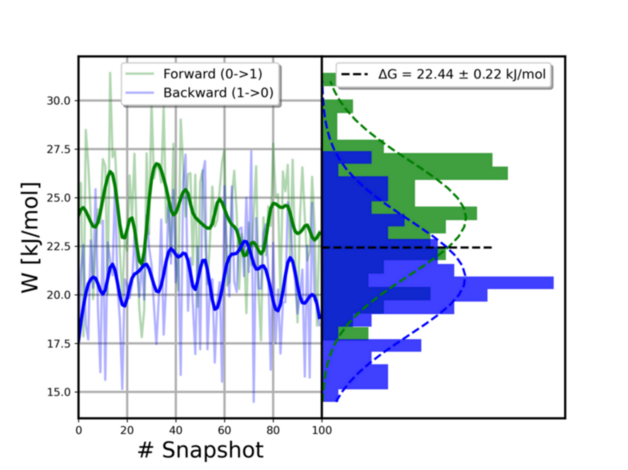

As you might have noticed, there is a **large overlap** between the forward and backward work distributions. In such as scenario, all the three estimators (BAR, CGI, and Janzynski) provide similar $\Delta G$ values; you can check in the results.txt file. 

BAR is also known to provide a better estimate of $\Delta G$ even in cases with a lesser (to no) work distributions overlap. The $\Delta G$ provided in the plot above is from BAR estimator, and the error is standard error obtained by bootstrapping of the work values.

Let's have a look at the BAR section of results.txt file.

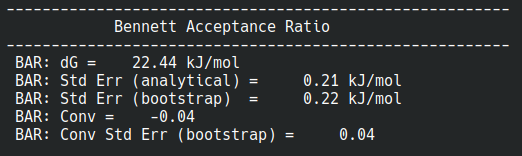

Another quantity, known as the convergence estimate (BAR: Conv), is also reported. It's value fluctuate around 0 for a converged work distribution (i.e. a good work distribution overlap). A value close to 1 represents no work distribution overlap and hence a lack of convergence.

**Finally**, we estimated the -$\Delta G_{solv.}$ (desolvation free energy) of aniline using non-equilibrium alchemical calculation to be **22.44 $\pm$ 0.22 kJ/mol**, which excellently matches with the **experimentally reported value of 22.96 kJ/mol** ([Reference](https://pubs.acs.org/doi/10.1021/acs.jced.7b00104)).

## Further 

Let's relax a bit and try to comprehend the potential of the tool we have now. 

With knowledge of two end states at hand, one could accurately estimate the free energy difference between them. The two end states can be imagined in a way that provide us
- The change of folding free energy due to protein (DNA/RNA) mutations (**Protein Engineering**). [Tutorial here](http://pmx.mpibpc.mpg.de/tutorial.html).
- The absolute/relative protein-ligand binding free energy (**Drug Design**). [RBFE tutorial here](https://github.com/deGrootLab/pmx/tree/develop/tutorials). ABFE tutorial coming up.
- The change in binding free energy of ligand due to protein mutations. Tutorial coming up.
- Protein-protein binding affinity change due to amino acid mutations. Tutorial coming up.
- The list goes on.

Although we've been very thourough with the protocol, there are a few parameters we took for granted. 
- If time permits one could reduce the transition time from 200 ps to 50 ps gradually and see how the $\Delta G$ estimate changes. One should not expect too a large variation as long as the two work distributions overlap.
- Multiple replicates of the entire protocol can be run to check its reproducibility.

**Got any question related to PMX? Ask at [https://ask.bioexcel.eu/](https://ask.bioexcel.eu/).**

## References and Further Reading

- Chipot C. , Christophe A. et al., Free Energy Calculations , **Springer Series in Chemical Physics**, Vol. 86. [[link]](https://link.springer.com/book/10.1007/978-3-540-38448-9)
- Vytautas Gapsys, Servaas Michielssens, Jan Henning Peters, Bert L. de Groot, Hadas Leonov. Calculation of Binding Free Energies. Molecular Modeling of proteins: 2nd edition. Book Series: **Methods in Molecular Biology** 1215: 173-209 (2015). [[link]](https://link.springer.com/protocol/10.1007/978-1-4939-1465-4_9)
- Gapsys V, Michielssens S, Seeliger D, and de Groot BL pmx: Automated protein structure and topology generation for alchemical perturbations. **J. Comp. Chem.** 36:348-354 (2015). [[link]](https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.23804)
- Goette M, Grubmuller H, Accuracy and convergence of free energy differences calculated from nonequilibrium switching processes. **J. Comp. Chem.** 30: 447-456 (2009). [[link]](https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.21073)